In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch.nn.functional as F

In [23]:
# Load and preprocess data
file_path = "./static_data_summary.csv"
data = pd.read_csv(file_path)

# Extract the 'totpop' column
totpop = data['totpop'].values

# Extract the real travel demand data from ridesourcing file
ridesourcing_file_path = "./Ridesourcing_CensusCount_ALL_0_Filled.csv"
ridesourcing_data = pd.read_csv(ridesourcing_file_path)

# Aggregate travel demand data by summing all time intervals for each census tract
travel_demand = ridesourcing_data.drop(columns=['index']).sum(axis=1).values

# Include 'totpop' in the features
features_list = ['totpop', 'SerHourBusRoutes', 'SerHourRailRoutes', 'BusStopDen', 'RailStationDen', 'popden', 'pctmale', 
                 'pctbachelor', 'young2', 'pcthisp', 'carown', 'pctlowinc', 'pctmidinc', 'pcthighinc', 
                 'pctsinfam2', 'CrimeDen', 'RdNetwkDen', 'InterstDen']
features = data[features_list].values

In [24]:
'''
# Load and preprocess data (from previous cells)
file_path = "./static_data_summary.csv"
data = pd.read_csv(file_path)

# Extract the 'totpop' column
totpop = data['totpop'].values

# Extract the real travel demand data from ridesourcing file 
ridesourcing_file_path = "./Ridesourcing_CensusCount_ALL_0_Filled.csv"
ridesourcing_data = pd.read_csv(ridesourcing_file_path)

# Aggregate travel demand data by summing all time intervals for each census tract
travel_demand = ridesourcing_data.drop(columns=['index']).sum(axis=1).values

# Extract features from the data
features = data[['SerHourBusRoutes', 'SerHourRailRoutes', 'BusStopDen', 'RailStationDen', 'popden', 'pctmale', 
                 'pctbachelor', 'young2', 'pcthisp', 'carown', 'pctlowinc', 'pctmidinc', 'pcthighinc', 
                 'pctsinfam2', 'CrimeDen', 'RdNetwkDen', 'InterstDen']].values
'''

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, travel_demand, test_size=0.2, random_state=42)

# Normalize the data
features_min = np.min(X_train, axis=0)
features_max = np.max(X_train, axis=0)
X_train_normalized = (X_train - features_min) / (features_max - features_min)
X_test_normalized = (X_test - features_min) / (features_max - features_min)

travel_demand_min = np.min(y_train)
travel_demand_max = np.max(y_train)
y_train_normalized = (y_train - travel_demand_min) / (travel_demand_max - travel_demand_min)
y_test_normalized = (y_test - travel_demand_min) / (travel_demand_max - travel_demand_min)

# Normalize populations
pop_min = np.min(totpop)
pop_max = np.max(totpop)
populations_normalized = (totpop - pop_min) / (pop_max - pop_min)

# Convert to tensors and move to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_normalized, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test_normalized, dtype=torch.float32).unsqueeze(1).to(device)
populations_tensor = torch.tensor(populations_normalized, dtype=torch.float32).to(device)


class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
    
    def step(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
            return False
        elif loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False
            
# Define the neural network model 
class EnhancedNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate):
        super(EnhancedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the calculate_monotonicity_penalty function (assuming this is already defined in your code)
def calculate_monotonicity_penalty(preds, populations, device):
    penalty = torch.tensor(0.0, device=device)
    for i in range(1, len(preds)):
        if preds[i] > preds[i - 1] and populations[i] < populations[i - 1]:
            penalty += torch.abs(preds[i] - preds[i - 1]).sum()
        elif preds[i] < preds[i - 1] and populations[i] > populations[i - 1]:
            penalty += torch.abs(preds[i] - preds[i - 1]).sum()
    return penalty

# Define the calculate_loss function
def calculate_loss(y_pred, label, criterion, lam, device, populations):
    cost1 = criterion(y_pred, label).double()
    monotonicity_penalty = calculate_monotonicity_penalty(y_pred, populations, device)
    cost = (1 - lam) * cost1 + lam * monotonicity_penalty
    return cost, cost1, monotonicity_penalty

# Define the calculate_accuracy function
def calculate_accuracy(model, X_test, y_test, travel_demand_min, travel_demand_max):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        y_pred_normalized = model(X_test).cpu().numpy()
    
    # Denormalize the predictions
    y_pred = y_pred_normalized * (travel_demand_max - travel_demand_min) + travel_demand_min
    y_test_denormalized = y_test.cpu().numpy() * (travel_demand_max - travel_demand_min) + travel_demand_min
    
    # Calculate MAE, RMSE, and MSE
    mae = mean_absolute_error(y_test_denormalized, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_denormalized, y_pred))
    mse = mean_squared_error(y_test_denormalized, y_pred)
    
    return mae, rmse, mse

In [25]:
# Define a function to train and evaluate the model with different lambda values
def experiment_with_monotonicity_lambda(lam_values, num_epochs, patience, min_delta, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, travel_demand_min, travel_demand_max, populations_tensor):
    results = []

    for lam in lam_values:
        print(f"\nTraining with lambda: {lam}")
        
        # Define model, criterion, and optimizer
        input_size = X_train_tensor.shape[1]
        hidden_size1 = 100
        hidden_size2 = 50
        output_size = 1
        dropout_rate = 0.3
        model = EnhancedNN(input_size, hidden_size1, hidden_size2, output_size, dropout_rate).to(device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

        # Training loop with early stopping
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            
            y_pred = model(X_train_tensor)
            loss, cost1, monotonicity_penalty = calculate_loss(y_pred, y_train_tensor, criterion, lam, device, populations_tensor)
            
            loss.backward()
            optimizer.step()
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Cost1: {cost1.item()}, Monotonicity Penalty: {monotonicity_penalty.item()}')

        print("Training completed")

        # Evaluate the model
        mae, rmse, mse = calculate_accuracy(model, X_test_tensor, y_test_tensor, travel_demand_min, travel_demand_max)
        #print(f'Lambda: {lam} - MAE: {mae}, RMSE: {rmse}, MSE: {mse}')
        
        results.append({
            'lambda': lam,
            'MAE': mae,
            'RMSE': rmse,
            'MSE': mse
        })
    
    return results

# Example usage
lam_values = [0, 0.2, 0.5, 0.8, 1]
num_epochs = 100
patience = 10
min_delta = 1e-4

results = experiment_with_monotonicity_lambda(lam_values, num_epochs, patience, min_delta, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, travel_demand_min, travel_demand_max, populations_tensor)

# Print results
for result in results:
    print(result)


Training with lambda: 0
Epoch [1/100], Loss: 0.04956639185547829, Cost1: 0.04956639185547829, Monotonicity Penalty: 11.802862167358398
Epoch [2/100], Loss: 0.03849758580327034, Cost1: 0.03849758580327034, Monotonicity Penalty: 9.764453887939453
Epoch [3/100], Loss: 0.02970411255955696, Cost1: 0.02970411255955696, Monotonicity Penalty: 10.141138076782227
Epoch [4/100], Loss: 0.022902121767401695, Cost1: 0.022902121767401695, Monotonicity Penalty: 9.569908142089844
Epoch [5/100], Loss: 0.01727236621081829, Cost1: 0.01727236621081829, Monotonicity Penalty: 10.033502578735352
Epoch [6/100], Loss: 0.012972230091691017, Cost1: 0.012972230091691017, Monotonicity Penalty: 9.607876777648926
Epoch [7/100], Loss: 0.009598975069820881, Cost1: 0.009598975069820881, Monotonicity Penalty: 9.441899299621582
Epoch [8/100], Loss: 0.00737715233117342, Cost1: 0.00737715233117342, Monotonicity Penalty: 9.18632984161377
Epoch [9/100], Loss: 0.005556299351155758, Cost1: 0.005556299351155758, Monotonicity Pe

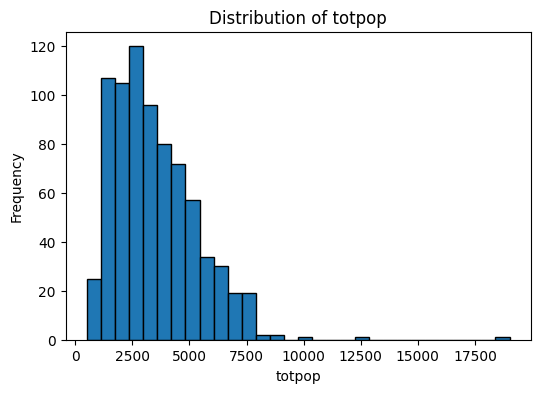

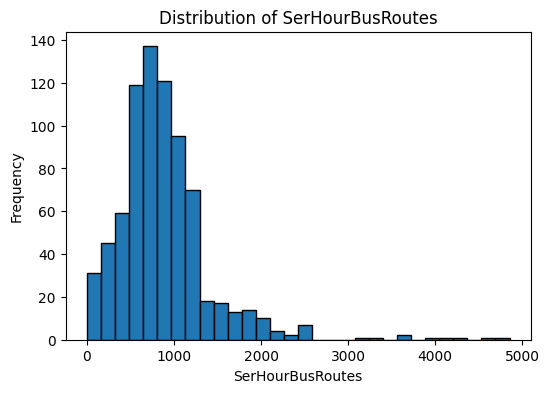

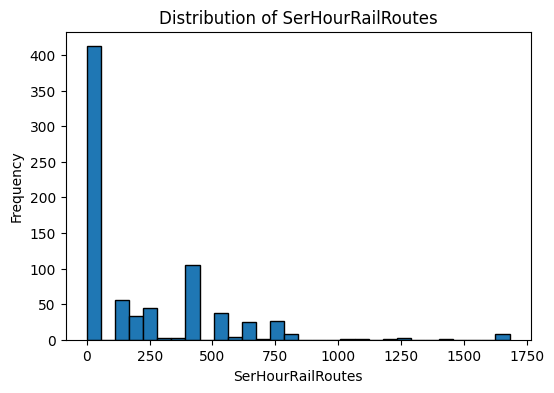

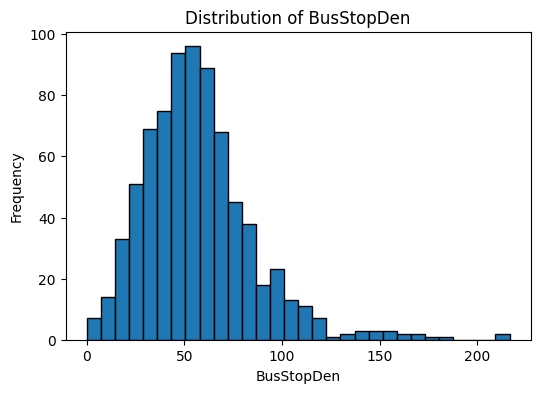

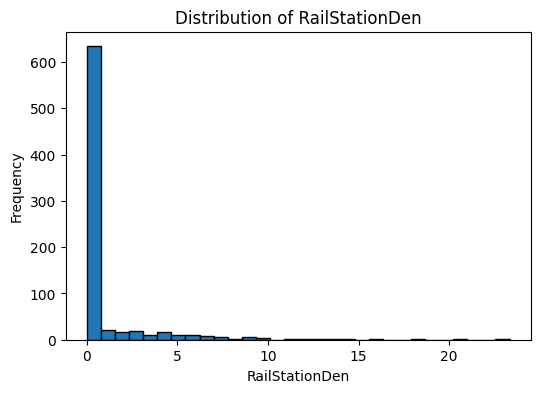

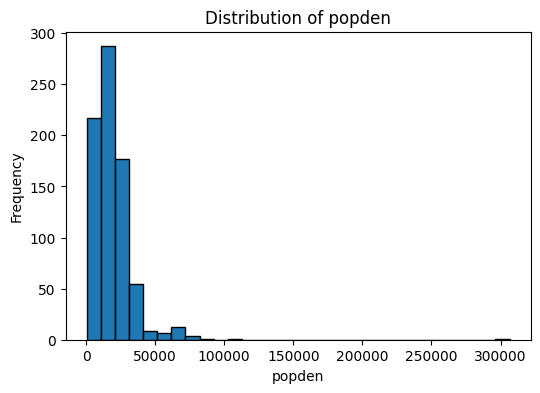

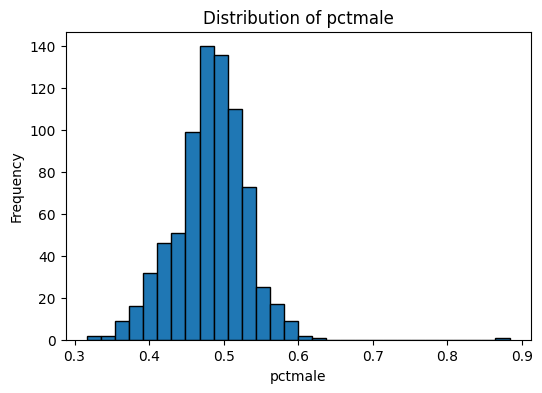

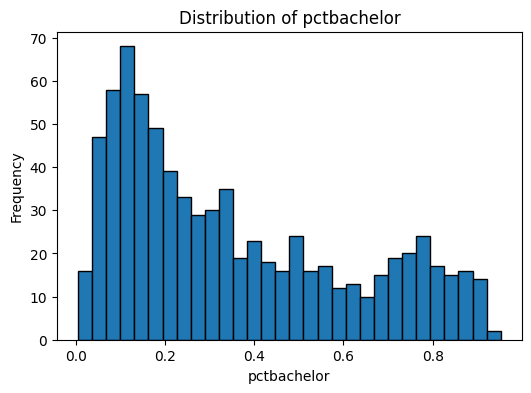

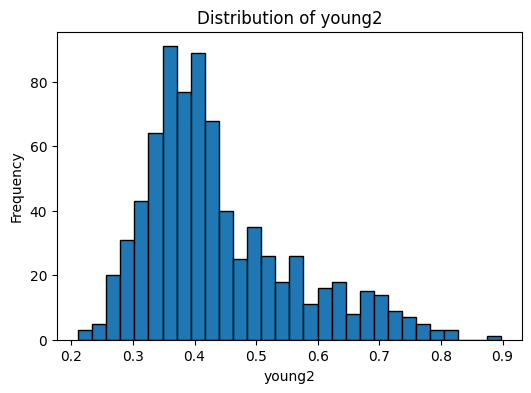

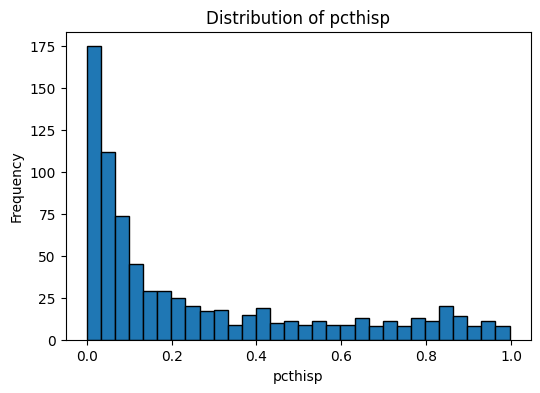

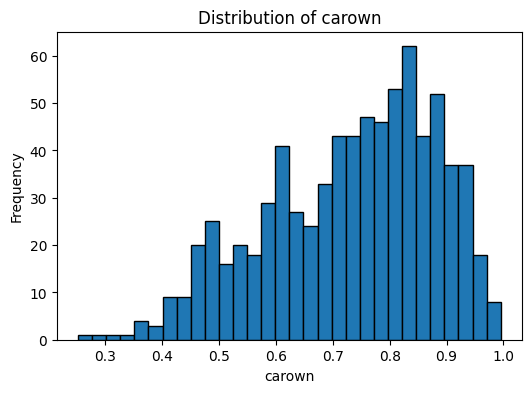

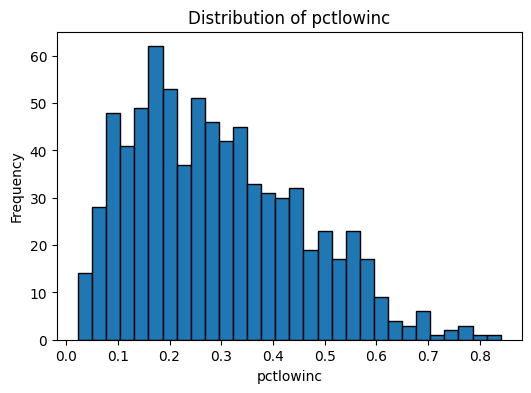

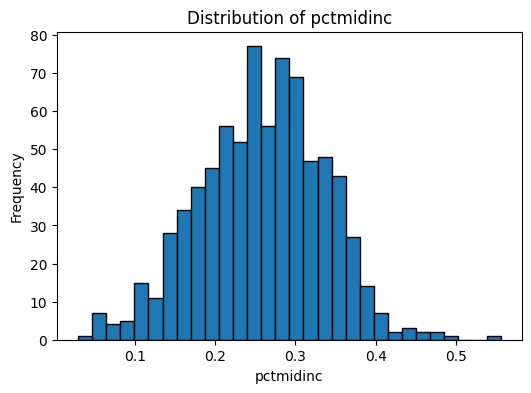

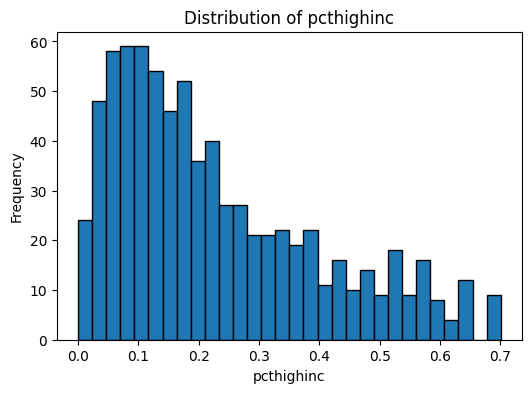

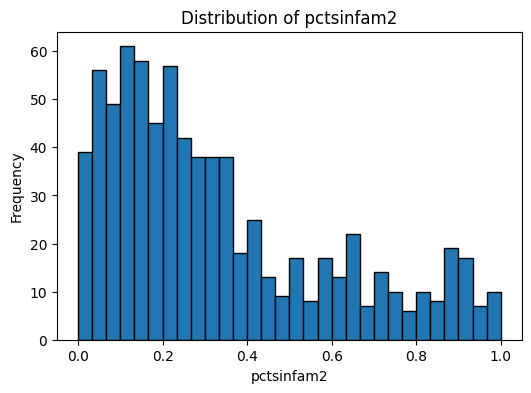

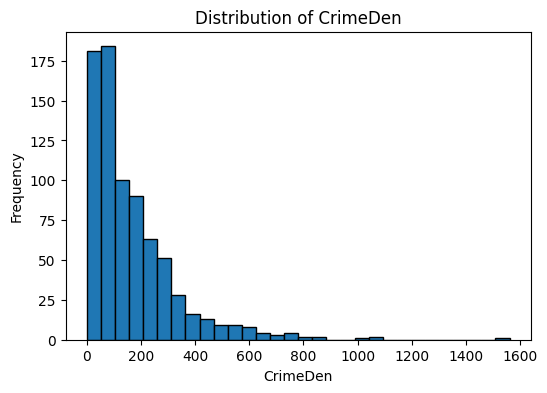

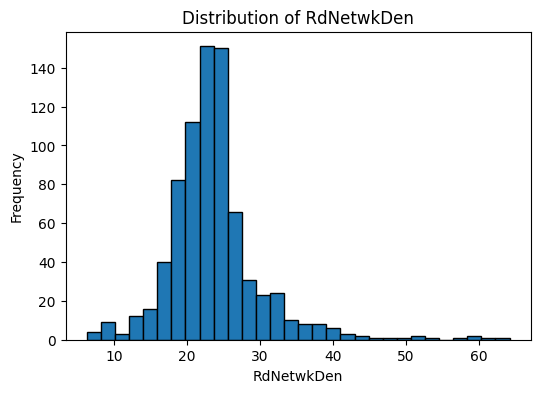

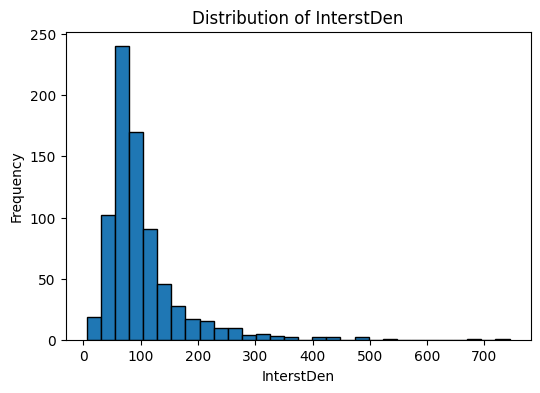

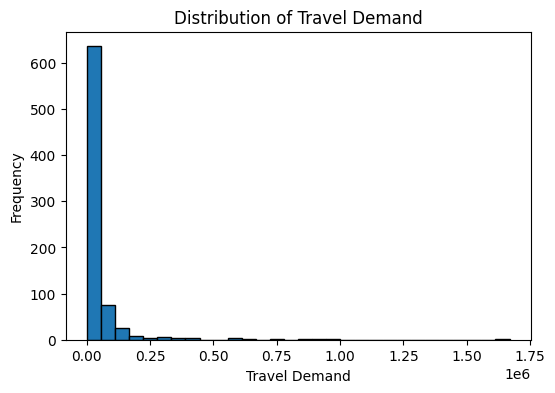

In [26]:
# Plot histograms of features
features_list = ['totpop', 'SerHourBusRoutes', 'SerHourRailRoutes', 'BusStopDen', 'RailStationDen', 'popden', 'pctmale', 
                 'pctbachelor', 'young2', 'pcthisp', 'carown', 'pctlowinc', 'pctmidinc', 'pcthighinc', 
                 'pctsinfam2', 'CrimeDen', 'RdNetwkDen', 'InterstDen']

for feature in features_list:
    plt.figure(figsize=(6, 4))
    plt.hist(data[feature], bins=30, edgecolor='k')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Plot histogram of the target variable (travel demand)
plt.figure(figsize=(6, 4))
plt.hist(travel_demand, bins=30, edgecolor='k')
plt.title('Distribution of Travel Demand')
plt.xlabel('Travel Demand')
plt.ylabel('Frequency')
plt.show()

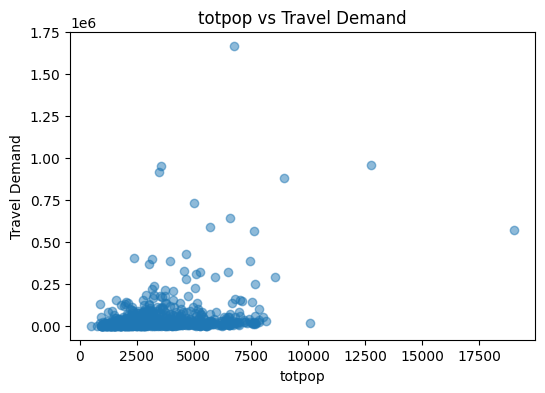

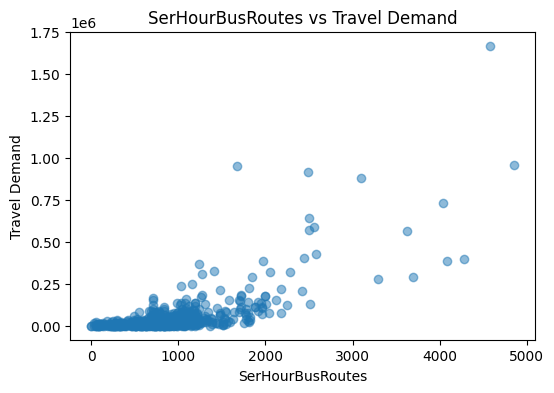

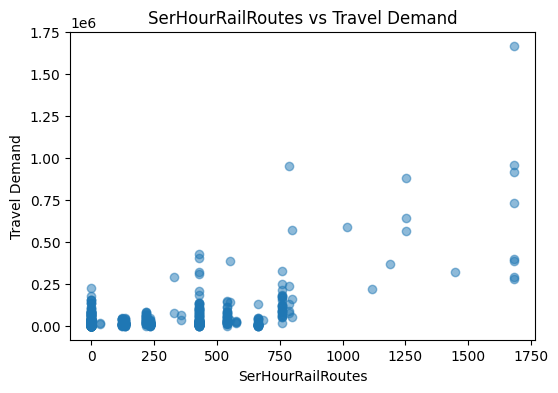

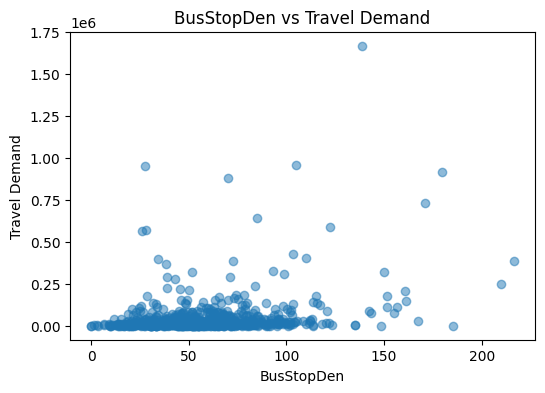

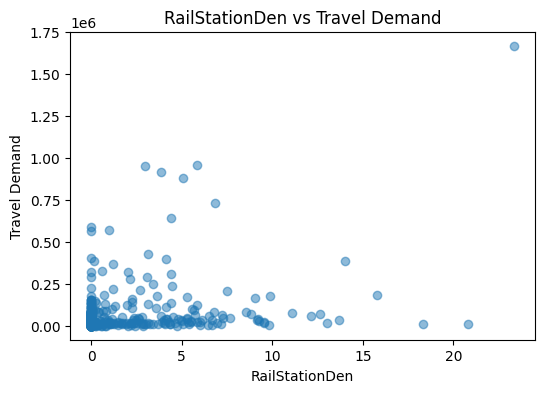

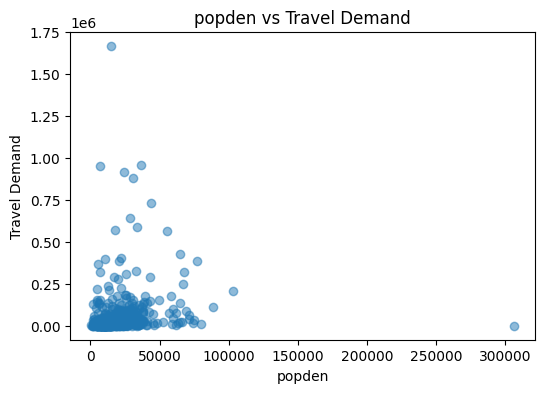

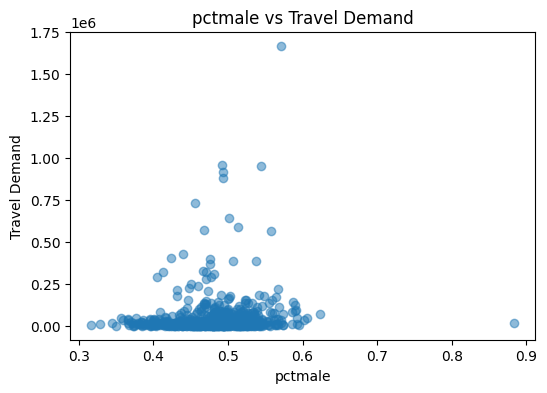

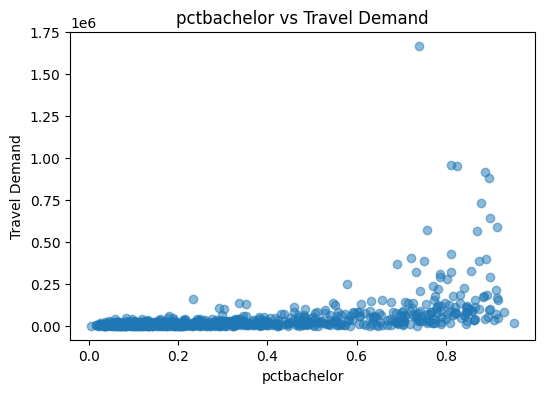

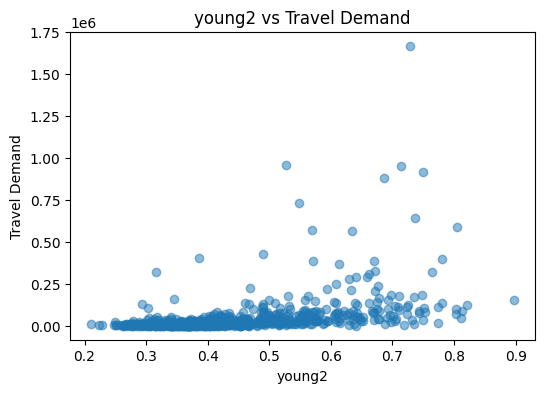

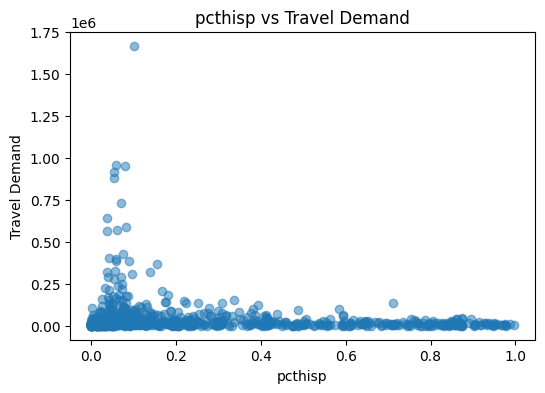

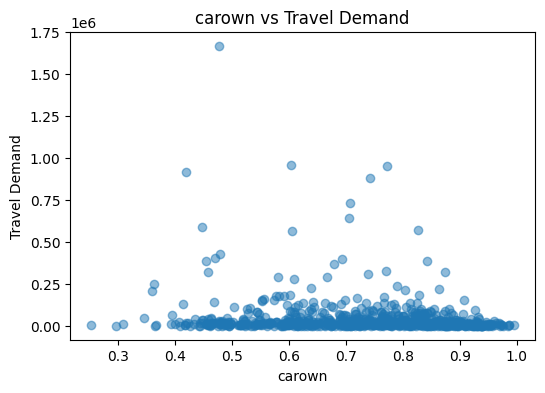

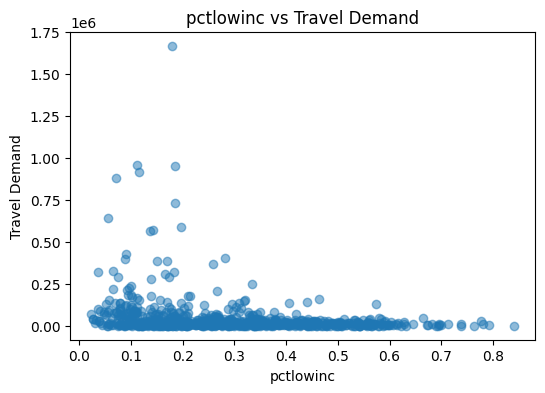

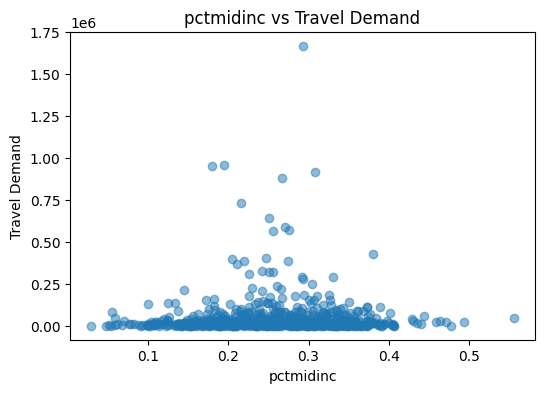

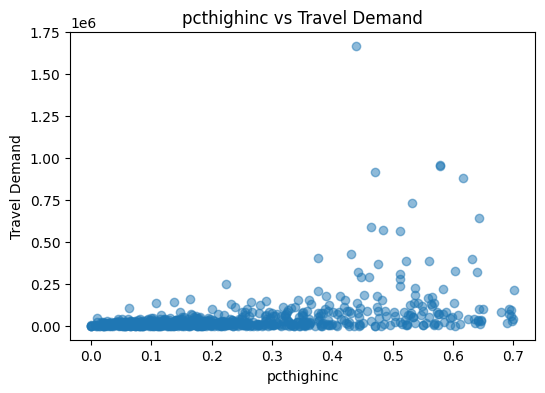

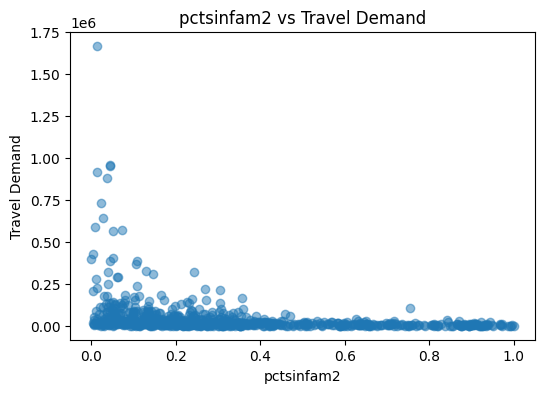

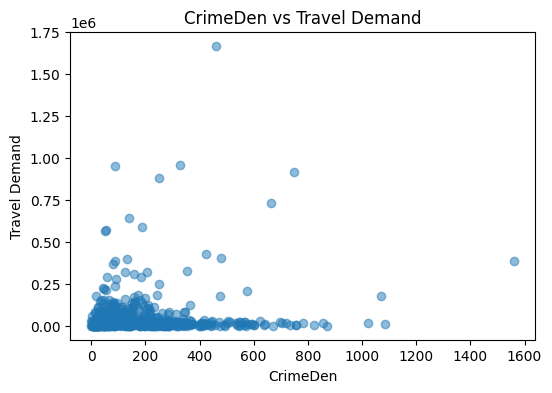

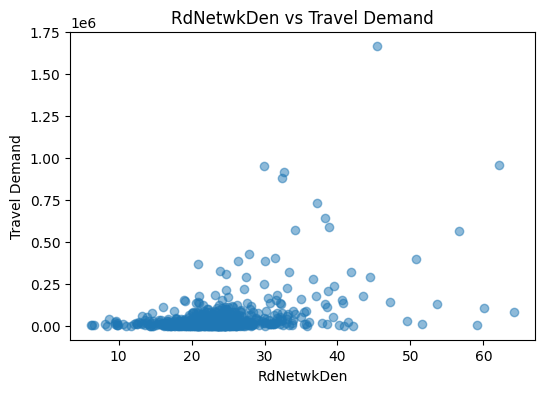

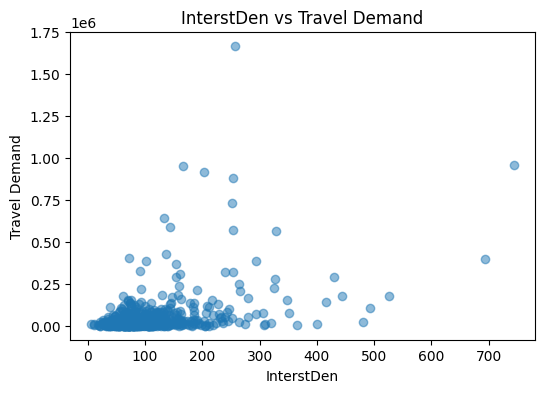

In [28]:
# Plot scatter plots to see the relationship between features and the target variable
for feature in features_list:
    plt.figure(figsize=(6, 4))
    plt.scatter(data[feature], travel_demand, alpha=0.5)
    plt.title(f'{feature} vs Travel Demand')
    plt.xlabel(feature)
    plt.ylabel('Travel Demand')
    plt.show()

In [27]:
# Calculate and print correlation coefficients
correlations = data[features_list].corrwith(pd.Series(travel_demand))
print(correlations)

totpop               0.289692
SerHourBusRoutes     0.696228
SerHourRailRoutes    0.599444
BusStopDen           0.284955
RailStationDen       0.362114
popden               0.160887
pctmale              0.098436
pctbachelor          0.453329
young2               0.436926
pcthisp             -0.148274
carown              -0.146902
pctlowinc           -0.228073
pctmidinc            0.007456
pcthighinc           0.388100
pctsinfam2          -0.272413
CrimeDen             0.124218
RdNetwkDen           0.404730
InterstDen           0.431563
dtype: float64
